# Preprocessing Multi-Omics Data and Generating Embeddings at Inference-time

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lab-rasool/HoneyBee/blob/main/examples/mayo/04_molecular/SeNMo_preprocessing_embeddings.ipynb)

SeNMo is a deep learning model designed to analyze multi-omics data across multiple cancer types. It integrates diverse molecular modalities such as gene expression, miRNA expression, DNA methylation, protein expression, DNA Mutation, and clinical data to predict patient outcomes with high accuracy. This page provides instructions to preprocess these data modalities and generate embeddings using the SeNMo model.

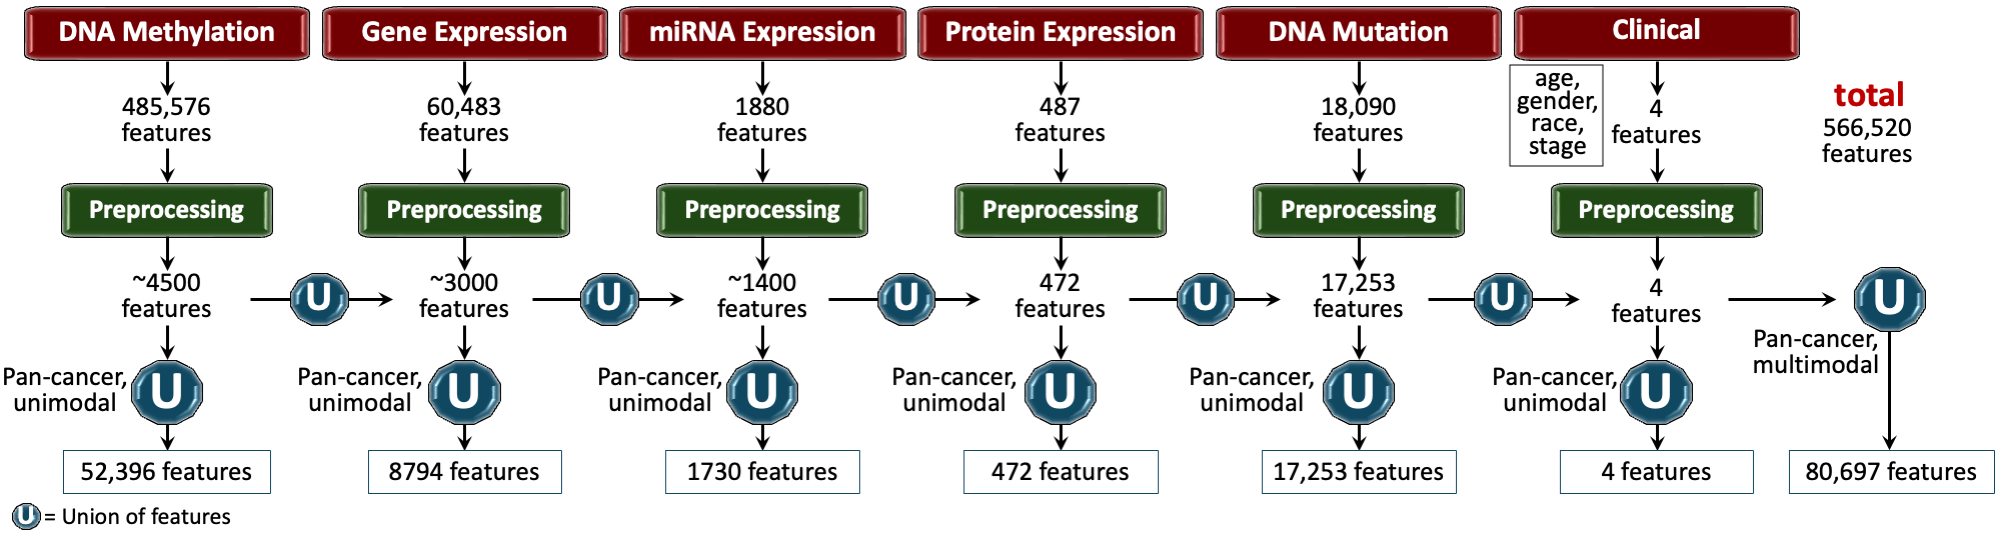

In [1]:
import pandas as pd
import random
import numpy as np
import pickle
import torch
import torch.nn as nn
from pathlib import Path

In [2]:
# Colab Setup Cell - Run this first!
import os
import sys

# Check if we're running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Not running in Google Colab")

if IN_COLAB:
    # Install required system dependencies
    !apt-get update && apt-get install -y openslide-tools tesseract-ocr

    # Download NLTK data
    import nltk
    nltk.download('punkt', quiet=True)

    # Clone HoneyBee repository
    if not os.path.exists('/content/HoneyBee'):
        !git clone https://github.com/lab-rasool/HoneyBee.git /content/HoneyBee

    # Add HoneyBee to Python path
    sys.path.append('/content/HoneyBee')

    # Install Python dependencies
    !curl -LsSf https://astral.sh/uv/install.sh | sh
    !uv pip install -r /content/HoneyBee/requirements.txt

    # Create necessary directories
    os.makedirs('/content/outputs', exist_ok=True)
    os.makedirs('/content/sample_data', exist_ok=True)

    # Download sample PDF (we'll need to provide a URL or use file upload)
    print("\n✅ Colab setup complete!")

else:
    # Local setup - use existing paths
    sys.path.append('/mnt/f/Projects/HoneyBee')
    print("Using local HoneyBee installation")



Running in Google Colab
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,752 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,078 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/un

## Step 1: Uni-modal Data Pre-processing

Preprocessing each modality individually is crucial to ensure that the data is cleaned, normalized, and structured in a way that preserves its unique characteristics. This step ensures that features from different modalities are properly aligned and contribute meaningfully to the final multi-omics integration and embedding generation. Preprocess individual modalities using the scripts provided for each type of data.

### 1. miRNA Expression

Preprocess miRNA expression data. The script standardizes and formats the raw miRNA data for downstream analysis.

In [3]:
class MiRNAPreprocessor:
    def __init__(self, input_file, output_file):
        """
        Initialize the preprocessor.

        :param input_file: Path to the input miRNA file (TSV format).
        :param output_file: Path to save the processed file (CSV format).
        """
        self.input_file = input_file
        self.output_file = output_file

    def load_and_transpose(self):
        """
        Load the miRNA file and transpose it.

        :return: Transposed DataFrame
        """
        data = pd.read_table(self.input_file)
        transposed_data = data.transpose()
        transposed_data.reset_index(inplace=True)
        transposed_data.columns = transposed_data.iloc[0]
        transposed_data = transposed_data[1:]
        transposed_data.rename(columns={transposed_data.columns[0]: 'sample'}, inplace=True)
        return transposed_data

    def drop_nans(self, data):
        """
        Drop rows with NaN values.

        :param data: DataFrame to process
        :return: DataFrame with NaN values dropped
        """
        return data.dropna()

    def adjust_feature_size(self, data, target_size=1731):
        """
        Ensure the number of features is equal to the target size by dropping zero-value columns if needed.

        :param data: DataFrame to process
        :param target_size: Desired number of features
        :return: Adjusted DataFrame
        """
        if data.shape[1] > target_size:
            # Identify columns with all zero values
            zero_columns = data.columns[(data == 0).all()]
            data = data.drop(columns=zero_columns[:data.shape[1] - target_size])
        return data

    def save_to_csv(self, data):
        """
        Save the processed data to a CSV file.

        :param data: DataFrame to save
        """
        print('file being saved to: ', self.output_file)
        data.to_csv(self.output_file, index=False)

    def process(self):
        """
        Perform the entire preprocessing pipeline.
        """
        print('Step 1: Load and transpose the data')
        data = self.load_and_transpose()

        print('Step 2: Drop NaN values')
        data = self.drop_nans(data)

        print('Step 3: Adjust the feature size if necessary')
        data = self.adjust_feature_size(data)

        print('Step 4: Save the final processed data')
        self.save_to_csv(data)

In [5]:
input_mirna = '/content/HoneyBee/examples/mayo/Molecular/inputs/1-sample-mirna.tsv'
output_mirna = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_mirna.csv'

mirna_preprocessor = MiRNAPreprocessor(input_mirna, output_mirna)
mirna_preprocessor.process()

Step 1: Load and transpose the data
Step 2: Drop NaN values
Step 3: Adjust the feature size if necessary
Step 4: Save the final processed data
file being saved to:  /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_mirna.csv


In [6]:
# load the file and print its contents
mirnafile_output = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_mirna.csv'
mirnafile_output = pd.read_csv(mirnafile_output)
print(mirnafile_output)
print(mirnafile_output.shape)

     sample  hsa-let-7a-1  hsa-let-7a-2  hsa-let-7a-3  hsa-let-7b  hsa-let-7c  \
0  Patient1     14.947924     14.940177     14.947834   15.869483   11.003827   

   hsa-let-7d  hsa-let-7e  hsa-let-7f-1  hsa-let-7f-2  ...  hsa-mir-941-5  \
0    9.317855   10.679092      13.37346     13.398557  ...            0.0   

   hsa-mir-942  hsa-mir-943  hsa-mir-944  hsa-mir-95  hsa-mir-9500  \
0     2.186163     0.479798     0.479798    2.705685           0.0   

   hsa-mir-96  hsa-mir-98  hsa-mir-99a  hsa-mir-99b  
0    4.577961    6.162374     8.089844    14.017836  

[1 rows x 1731 columns]
(1, 1731)


### 2. DNA Methylation

Preprocess DNA methylation data. The script filters and normalizes methylation profiles from raw input files.

#### ❗❗ NOTE
*   The input file size for Methylation data is very large even for a single sample, ~4GB. For this activity, we have provided the pre-processed output file for you. Also the code has been provided below for future use.
*   *Skip* running the next two cells

#### ❗❗

In [7]:
class DNAMethylationPreprocessor:
    def __init__(self, input_file, output_file):
        """
        Initialize the preprocessor.

        :param input_file: Path to the input DNA methylation file (TSV format).
        :param output_file: Path to save the processed file (CSV format).
        """
        self.input_file = input_file
        self.output_file = output_file

    def load_and_transpose(self):
        """
        Load the methylation file and transpose it.

        :return: Transposed DataFrame
        """
        data = pd.read_table(self.input_file)
        print("Input data shape:", data.shape)
        # Transpose data and reset index
        transposed_data = data.transpose()
        transposed_data.reset_index(inplace=True)
        # Ensure column names are correctly set
        transposed_data.columns = transposed_data.iloc[0]
        transposed_data = transposed_data[1:]
        transposed_data.rename(columns={transposed_data.columns[0]: 'sample'}, inplace=True)
        return transposed_data

    def drop_nans(self, data):
        """
        Drop rows with NaN values.

        :param data: DataFrame to process
        :return: DataFrame with NaN values dropped
        """
        return data.dropna(axis=1, how='all')  # Drop columns where all values are NaN

    def adjust_feature_size(self, data, target_size=52396):
        """
        Adjust the feature size to the target size by removing features stepwise.

        :param data: DataFrame to process
        :param target_size: Desired number of features
        :return: Adjusted DataFrame
        """
        print("Initial data shape:", data.shape)
        numeric_data = data.iloc[:, 1:].astype(float)  # Assuming first column is sample ID

        # Stepwise removal of features
        intervals = [
            (0, 0),
            (0, 0.1),
            (0.1, 0.2),
            (0.2, 0.3),
            (0.3, 0.4),
            (0.4, 0.5),
            (0.5, 0.6),
            (0.6, 0.7),
            (0.7, 0.8),
            (0.8, 0.9),
            (0.9, 1.0)
        ]

        for lower, upper in intervals:
            if numeric_data.shape[1] > target_size:
                condition = (numeric_data > lower).all() & (numeric_data <= upper).all()
                columns_to_remove = numeric_data.columns[condition]
                to_remove = len(numeric_data.columns) - target_size
                numeric_data = numeric_data.drop(columns=columns_to_remove[:to_remove])
                print(f"After removing features with values ({lower}, {upper}], shape:", numeric_data.shape)

        # Raise exception if target size is not achieved
        if numeric_data.shape[1] > target_size:
            raise Exception(f"Number of features is still greater than {target_size} after all adjustments.")

        # Reconstruct the full DataFrame
        numeric_data.insert(0, 'sample', data.iloc[:, 0])  # Re-add the sample column
        print("Final data shape:", numeric_data.shape)
        return numeric_data

    def save_to_csv(self, data):
        """
        Save the processed data to a CSV file.

        :param data: DataFrame to save
        """
        print("Output data shape:", data.shape)
        data.to_csv(self.output_file, index=False)

    def process(self):
        """
        Perform the entire preprocessing pipeline.
        """
        # Step 1: Load and transpose the data
        data = self.load_and_transpose()

        # Step 2: Drop NaN values
        data = self.drop_nans(data)

        # Step 3: Adjust the feature size if necessary
        data = self.adjust_feature_size(data)

        # Step 4: Save the final processed data
        self.save_to_csv(data)

In [ ]:
# input_methyl = '/content/HoneyBee/examples/mayo/Molecular/inputs/1-sample-methylation450.tsv' # File size: 3.8GB, skip running the code for now
# output_methyl = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_DNAMethyl.csv' # already provided in the outputs folder

# DNAMethyl_preprocessor = DNAMethylationPreprocessor(input_methyl, output_methyl)
# DNAMethyl_preprocessor.process()

In [8]:
# load the file and print its contents
methylfile_output = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_DNAMethyl.csv'
methylfile_output = pd.read_csv(methylfile_output)
print(methylfile_output)
print(methylfile_output.shape)

     sample  cg00000721  cg00001687  cg00002809  cg00004067  cg00004883  \
0  Patient1     0.92785    0.982995    0.902113    0.931502    0.958292   

   cg00004979  cg00007036  cg00007324  cg00007466  ...  cg12777178  \
0    0.955822    0.964631    0.979308    0.903823  ...    0.913755   

   cg12778183  cg12780124  cg12781405  cg12782201  cg12783348  cg12785983  \
0    0.977743    0.900388    0.934577    0.952366    0.911289    0.914114   

   cg12787292  cg12788159  cg12789259  
0    0.920296    0.963293    0.908231  

[1 rows x 16384 columns]
(1, 16384)


### 3. Gene Expression

Preprocess gene expression data. The script converts raw gene expression data into a standardized format compatible with multi-omics integration.

In [9]:
class GeneExpressionPreprocessor:
    def __init__(self, input_file, output_file):
        """
        Initialize the preprocessor.

        :param input_file: Path to the input gene expression file (TSV format).
        :param output_file: Path to save the processed file (CSV format).
        """
        self.input_file = input_file
        self.output_file = output_file

    def load_and_transpose(self):
        """
        Load the gene expression file and transpose it.

        :return: Transposed DataFrame
        """
        data = pd.read_table(self.input_file)
        print("Input data shape:", data.shape)
        # Transpose data and reset index
        transposed_data = data.transpose()
        transposed_data.reset_index(inplace=True)
        # Ensure column names are correctly set
        transposed_data.columns = transposed_data.iloc[0]
        transposed_data = transposed_data[1:]
        transposed_data.rename(columns={transposed_data.columns[0]: 'sample'}, inplace=True)
        return transposed_data

    def drop_nans(self, data):
        """
        Drop rows with NaN values.

        :param data: DataFrame to process
        :return: DataFrame with NaN values dropped
        """
        return data.dropna(axis=1, how='all')  # Drop columns where all values are NaN

    def adjust_feature_size(self, data, target_size=8794):
        """
        Adjust the feature size to the target size by removing features stepwise.

        :param data: DataFrame to process
        :param target_size: Desired number of features
        :return: Adjusted DataFrame
        """
        print("Initial data shape:", data.shape)
        numeric_data = data.iloc[:, 1:].astype(float)  # Assuming first column is sample ID

        # Step 1: Remove zero-value columns until target size is reached
        zero_columns = numeric_data.columns[(numeric_data == 0).all()]
        if len(zero_columns) > 0:
            to_remove = len(numeric_data.columns) - target_size
            numeric_data = numeric_data.drop(columns=zero_columns[:to_remove])
            print("After removing zero-value features, shape:", numeric_data.shape)

        # Step 2: Remove columns with values < 7 until target size is reached
        if numeric_data.shape[1] > target_size:
            low_expr_columns = numeric_data.columns[(numeric_data < 7).all()]
            to_remove = len(numeric_data.columns) - target_size
            numeric_data = numeric_data.drop(columns=low_expr_columns[:to_remove])
            print("After removing features with values < 7, shape:", numeric_data.shape)

        # Step 3: Raise exception if target size is still not achieved
        if numeric_data.shape[1] > target_size:
            raise Exception(f"Number of features is still greater than {target_size} after all adjustments.")

        # Reconstruct the full DataFrame
        numeric_data.insert(0, 'sample', data.iloc[:, 0])  # Re-add the sample column
        print("Final data shape:", numeric_data.shape)
        return numeric_data

    def save_to_csv(self, data):
        """
        Save the processed data to a CSV file.

        :param data: DataFrame to save
        """
        print("Output data shape:", data.shape)
        data.to_csv(self.output_file, index=False)

    def process(self):
        """
        Perform the entire preprocessing pipeline.
        """
        print('Step 1: Load and transpose the data')
        data = self.load_and_transpose()

        print('Step 2: Drop NaN values')
        data = self.drop_nans(data)

        print('Step 3: Adjust the feature size if necessary')
        data = self.adjust_feature_size(data)

        print('Step 4: Save the final processed data')
        self.save_to_csv(data)


In [10]:
input_gene = '/content/HoneyBee/examples/mayo/Molecular/inputs/1-sample-GeneExpress.tsv'
output_gene = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_GeneExpress.csv'

GeneExpr_preprocessor = GeneExpressionPreprocessor(input_gene, output_gene)
GeneExpr_preprocessor.process()

Step 1: Load and transpose the data
Input data shape: (60483, 2)
Step 2: Drop NaN values
Step 3: Adjust the feature size if necessary
Initial data shape: (1, 60484)
After removing zero-value features, shape: (1, 33228)
After removing features with values < 7, shape: (1, 8794)
Final data shape: (1, 8795)
Step 4: Save the final processed data
Output data shape: (1, 8795)


In [11]:
# load the file and print its contents
genefile_output = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_GeneExpress.csv'
genefile_output = pd.read_csv(genefile_output)
print(genefile_output)
print(genefile_output.shape)

     sample  ENSG00000225630.1  ENSG00000211950.2  ENSG00000227097.5  \
0  Patient1           7.399619           8.965383           7.780726   

   ENSG00000198888.2  ENSG00000116285.11  ENSG00000224650.2  \
0          11.601781            7.092783           8.629284   

   ENSG00000149925.15  ENSG00000211679.2  ENSG00000211459.2  ...  \
0            7.490408           9.474671           8.290757  ...   

   ENSG00000146707.13  ENSG00000135094.9  ENSG00000231612.1  \
0            2.218044           1.765237           0.141561   

   ENSG00000238300.1  ENSG00000203729.7  ENSG00000009694.12  \
0           0.361179           0.044238            0.144596   

   ENSG00000267117.1  ENSG00000105063.17  ENSG00000231119.2  ENSG00000123685.7  
0           0.334857            5.060513           0.205208           3.016487  

[1 rows x 8795 columns]
(1, 8795)


### 4. Protein Expression

Preprocess protein expression data. This script processes RPPA data into a usable format for analysis.

In [12]:
class ProteinExpressionPreprocessor:
    def __init__(self, input_file, output_file):
        """
        Initialize the preprocessor.

        :param input_file: Path to the input protein expression file (TSV format).
        :param output_file: Path to save the processed file (CSV format).
        """
        self.input_file = input_file
        self.output_file = output_file

    def load_data(self):
        """
        Load the protein expression file and filter the necessary columns.

        :return: Filtered DataFrame
        """
        data = pd.read_table(self.input_file)
        print("Input data shape:", data.shape)
        if 'AGID' not in data.columns or 'protein_expression' not in data.columns:
            raise Exception("Required columns 'AGID' and 'protein_expression' are missing from the input file.")
        filtered_data = data[['AGID', 'protein_expression']]
        print("Filtered data shape:", filtered_data.shape)
        return filtered_data

    def calculate_mean(self, data):
        """
        Calculate the mean of the 'protein_expression' column.

        :param data: DataFrame to process
        :return: Mean value of 'protein_expression'
        """
        protein_expression_mean = data['protein_expression'].astype(float).mean()
        print(f"Mean value of 'protein_expression': {protein_expression_mean}")
        return protein_expression_mean

    def adjust_feature_size(self, data, target_size=472, mean_value=None):
        """
        Adjust the feature size to the target size by removing and imputing features.

        :param data: DataFrame to process
        :param target_size: Desired number of features
        :param mean_value: Precomputed mean value for 'protein_expression'
        :return: Adjusted DataFrame
        """
        print("Initial data shape:", data.shape)

        # Drop NaN-valued rows randomly until target size is reached
        nan_indices = data.index[data['protein_expression'].isnull()]
        excess = data.shape[0] - target_size
        if excess > 0 and len(nan_indices) > 0:
            drop_indices = nan_indices[:excess]
            data = data.drop(index=drop_indices)
            print(f"Dropped {len(drop_indices)} NaN-valued rows to match target size.")

        # Impute remaining NaNs with the mean of 'protein_expression'
        if 'protein_expression' in data.columns and mean_value is not None:
            data['protein_expression'] = data['protein_expression'].fillna(mean_value)
            print("Imputed missing values in 'protein_expression' with mean value.")

        # Verify no NaN values remain
        if data['protein_expression'].isnull().any():
            raise Exception("There are still missing values after imputation.")

        # Raise exception if target size is still not achieved
        if data.shape[0] > target_size:
            raise Exception(f"Number of features is still greater than {target_size} after all adjustments.")

        print("Final data shape:", data.shape)
        return data

    def transpose_data(self, data):
        """
        Transpose the data for further processing.

        :param data: DataFrame to transpose
        :return: Transposed DataFrame
        """
        transposed_data = data.transpose()
        transposed_data.reset_index(inplace=True)
        transposed_data.columns = transposed_data.iloc[0]
        transposed_data = transposed_data[1:]
        transposed_data.rename(columns={transposed_data.columns[0]: 'sample'}, inplace=True)
        return transposed_data

    def save_to_csv(self, data):
        """
        Save the processed data to a CSV file.

        :param data: DataFrame to save
        """
        print("Output data shape:", data.shape)
        data.to_csv(self.output_file, index=False)

    def process(self):
        """
        Perform the entire preprocessing pipeline.
        """
        print('Step 1: Load and filter the data')
        data = self.load_data()

        print('Step 2: Calculate the mean of protein_expression')
        mean_value = self.calculate_mean(data)

        print('Step 3: Adjust the feature size and impute missing values')
        data = self.adjust_feature_size(data, mean_value=mean_value)

        print('Step 4: Transpose the data')
        data = self.transpose_data(data)

        print('Step 5: Save the final processed data')
        self.save_to_csv(data)

In [13]:
input_protein = '/content/HoneyBee/examples/mayo/Molecular/inputs/1-sample_RPPA_data.tsv'
output_protein = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_RPPA.csv'

ProteinExpr_preprocessor = ProteinExpressionPreprocessor(input_protein, output_protein)
ProteinExpr_preprocessor.process()

Step 1: Load and filter the data
Input data shape: (487, 6)
Filtered data shape: (487, 2)
Step 2: Calculate the mean of protein_expression
Mean value of 'protein_expression': 0.0007337477938730896
Step 3: Adjust the feature size and impute missing values
Initial data shape: (487, 2)
Dropped 15 NaN-valued rows to match target size.
Imputed missing values in 'protein_expression' with mean value.
Final data shape: (472, 2)
Step 4: Transpose the data
Step 5: Save the final processed data
Output data shape: (1, 473)


In [14]:
# load the file and print its contents
proteinfile_output = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_RPPA.csv'
proteinfile_output = pd.read_csv(proteinfile_output)
print(proteinfile_output)
print(proteinfile_output.shape)

               sample  AGID00100  AGID00111  AGID00101  AGID00001  AGID00002  \
0  protein_expression  -0.030802    0.22584   0.038356    0.31273   -0.45164   

   AGID00003  AGID00443  AGID00120  AGID00004  ...  AGID00349  AGID02137  \
0     -0.198   -0.26213   0.093712    0.55881  ...  -0.188498   0.099685   

   AGID00088  AGID00089  AGID00504  AGID00095  AGID02217  AGID02210  \
0   -0.20796  -0.091886   -0.23627   -0.28587   0.020739  -0.435016   

   AGID00326  AGID00432  
0   0.037457   0.178993  

[1 rows x 473 columns]
(1, 473)


### 5. DNA Mutation

Preprocess DNA mutation data. The script maps mutation profiles to a standard gene nomenclature and extracts relevant features. We will require Hugo_symbols.csv as well.

In [15]:
class DNAMutationPreprocessor:
    def __init__(self, input_file, labels_file, output_file):
        """
        Initialize the preprocessor.

        :param input_file: Path to the input DNA mutation file (MAF format).
        :param labels_file: Path to the file containing Hugo Symbols (labels).
        :param output_file: Path to save the processed file (CSV format).
        """
        self.input_file = input_file
        self.labels_file = labels_file
        self.output_file = output_file

    def load_labels(self):
        """
        Load the labels file containing Hugo Symbols.

        :return: List of Hugo Symbols
        """
        labels = pd.read_csv(self.labels_file, sep='\t', header=None)
        labels_list = labels[0].tolist()
        print(f"Loaded {len(labels_list)} labels.")
        return labels_list

    def load_data(self):
        """
        Load the DNA mutation file and create a binary dataframe based on labels.

        :return: Binary DataFrame
        """
        data = pd.read_csv(self.input_file, sep='\t', comment='#', low_memory=False)
        print("Input data shape:", data.shape)
        if 'Hugo_Symbol' not in data.columns or 'IMPACT' not in data.columns:
            raise Exception("Required columns 'Hugo_Symbol' and 'IMPACT' are missing from the input file.")

        # Load labels
        labels = self.load_labels()

        # Create a dictionary for binary values based on 'IMPACT' == 'HIGH'
        binary_dict = {label: 0 for label in labels}
        high_impact_symbols = data.loc[data['IMPACT'] == 'HIGH', 'Hugo_Symbol']

        for symbol in high_impact_symbols:
            if symbol in binary_dict:
                binary_dict[symbol] = 1

        # Convert dictionary to DataFrame
        binary_df = pd.DataFrame(list(binary_dict.items()), columns=['Hugo_Symbol', 'DNA_Mut_values'])
        print("Binary DataFrame shape:", binary_df.shape)
        return binary_df

    def adjust_feature_size(self, data, target_size=17301):
        """
        Adjust the feature size to the target size by randomly removing features with 0 values.

        :param data: DataFrame to process
        :param target_size: Desired number of features
        :return: Adjusted DataFrame
        """
        print("Initial data shape:", data.shape)

        zero_value_indices = data.index[data['DNA_Mut_values'] == 0].tolist()
        excess = data.shape[0] - target_size

        # Randomly drop rows with 0 values to match the target size
        if excess > 0:
            drop_indices = random.sample(zero_value_indices, excess)
            data = data.drop(index=drop_indices)
            print(f"Dropped {len(drop_indices)} rows with 0 values to match target size.")

        print("Final data shape:", data.shape)
        return data

    def transpose_data(self, data):
        """
        Transpose the data so that the feature names are in the first row and values in the second.

        :param data: DataFrame to transpose
        :return: Transposed DataFrame
        """
        transposed_data = data.set_index('Hugo_Symbol').transpose()
        print("Transposed data shape:", transposed_data.shape)
        return transposed_data

    def save_to_csv(self, data):
        """
        Save the processed data to a CSV file.

        :param data: DataFrame to save
        """
        print("Output data shape:", data.shape)
        data.to_csv(self.output_file, index=False)

    def process(self):
        """
        Perform the entire preprocessing pipeline.
        """
        print('Step 1: Load and filter the data')
        data = self.load_data()

        print('Step 2: Adjust the feature size')
        data = self.adjust_feature_size(data)

        print('Step 3: Transpose the data')
        data = self.transpose_data(data)

        print('Step 4: Save the final processed data')
        self.save_to_csv(data)

In [16]:
input_dnamut = '/content/HoneyBee/examples/mayo/Molecular/inputs/wxs.aliquot_ensemble_masked.maf'
lables_file = '/content/HoneyBee/examples/mayo/Molecular/inputs/Hugo_symbols.tsv'
output_dnamut = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_DNAMut.csv'

DNAMut_preprocessor = DNAMutationPreprocessor(input_dnamut, lables_file, output_dnamut)
DNAMut_preprocessor.process()

Step 1: Load and filter the data
Input data shape: (47, 140)
Loaded 17312 labels.
Binary DataFrame shape: (17312, 2)
Step 2: Adjust the feature size
Initial data shape: (17312, 2)
Dropped 11 rows with 0 values to match target size.
Final data shape: (17301, 2)
Step 3: Transpose the data
Transposed data shape: (1, 17301)
Step 4: Save the final processed data
Output data shape: (1, 17301)


In [17]:
# load the file and print its contents
DNAmutfile_output = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_DNAMut.csv'
DNAmutfile_output = pd.read_csv(DNAmutfile_output)
print(DNAmutfile_output)
print(DNAmutfile_output.shape)

   HLTF  RB1  IL1B  AC090517.4  SPACA3  SOX10  USP9X  DEFB118  SYTL1  ITGA10  \
0     0    0     0           0       0      0      0        0      0       0   

   ...  METTL26  MECR  RBM8A  FAM43B  RPL27  DDX3Y  BGLAP  PYDC1  GPR31  C1QBP  
0  ...        0     0      0       0      0      0      0      0      0      0  

[1 rows x 17301 columns]
(1, 17301)


### 6. Clinical Data

Preprocess clinical data. This script processes phenotype files into structured datasets for multi-omics integration.

In [18]:
class ClinicalDataPreprocessor:
    def __init__(self, input_file, output_file):
        """
        Initialize the preprocessor.

        :param input_file: Path to the input clinical data file (TSV format).
        :param output_file: Path to save the processed file (CSV format).
        """
        self.input_file = input_file
        self.output_file = output_file

    def load_data(self):
        """
        Load the clinical data file and filter the required columns.

        :return: Filtered DataFrame
        """
        data = pd.read_csv(self.input_file, sep='\t', low_memory=False)
        print("Input data shape:", data.shape)

        required_columns = {
            'age_at_index.demographic': 'age',
            'gender.demographic': 'gender',
            'race.demographic': 'race',
            'tumor_stage.diagnoses': 'stage'
        }

        for col in required_columns:
            if col not in data.columns:
                raise Exception(f"Required column '{col}' is missing from the input file.")

        # Rename columns
        data = data[list(required_columns.keys())]
        data.rename(columns=required_columns, inplace=True)

        print("Filtered and renamed data shape:", data.shape)
        return data

    def convert_categorical_to_numerical(self, data):
        """
        Convert categorical columns to numerical values.

        :param data: DataFrame to process
        :return: DataFrame with converted columns
        """
        # Convert 'age' to float
        data['age'] = data['age'].astype(float)

        # Map values for 'gender'
        gender_map = {'male': 1, 'female': 2}
        data['gender'] = data['gender'].map(gender_map)

        # Map values for 'race'
        race_map = {
            'white': 1,
            'asian': 2,
            'black or african american': 3,
            'not reported': 4,
            'american indian or alaska native': 5
        }
        data['race'] = data['race'].map(race_map)

        # Map values for 'stage'
        stage_map = {
            'stage 0': 1,
            'is': 10, 'stage i': 10,
            'stage ia': 11, 'stage ib': 12, 'stage ic': 13,
            'stage ii': 20, 'i/ii nos': 20,
            'stage iia': 21, 'stage iib': 22, 'stage iic': 23,
            'stage iii': 30, 'stage iiia': 31, 'stage iiib': 32, 'stage iiic': 33,
            'stage iv': 40, 'stage iva': 41, 'stage ivb': 42, 'stage ivc': 43,
            'not reported': 50, 'stage x': 50
        }
        data['stage'] = data['stage'].map(stage_map)

        print("Converted categorical data to numerical values.")
        return data

    def save_to_csv(self, data):
        """
        Save the processed data to a CSV file.

        :param data: DataFrame to save
        """
        print("Output data shape:", data.shape)
        data.to_csv(self.output_file, index=False)

    def process(self):
        """
        Perform the entire preprocessing pipeline.
        """
        print('Step 1: Load and filter the data')
        data = self.load_data()

        print('Step 2: Convert categorical columns to numerical values')
        data = self.convert_categorical_to_numerical(data)

        print('Step 3: Save the final processed data')
        self.save_to_csv(data)

In [19]:
input_clin = '/content/HoneyBee/examples/mayo/Molecular/inputs/1-sample-GDC_phenotype.tsv'
output_clin = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_Clinical.csv'

Clin_preprocessor = ClinicalDataPreprocessor(input_clin, output_clin)
Clin_preprocessor.process()

Step 1: Load and filter the data
Input data shape: (1, 140)
Filtered and renamed data shape: (1, 4)
Step 2: Convert categorical columns to numerical values
Converted categorical data to numerical values.
Step 3: Save the final processed data
Output data shape: (1, 4)


In [20]:
# load the file and print its contents
Clinfile_output = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_Clinical.csv'
Clinfile_output = pd.read_csv(Clinfile_output)
print(Clinfile_output)
print(Clinfile_output.shape)

    age  gender  race  stage
0  63.0       2     1     22
(1, 4)


## Step 2: Combine Preprocessed Unimodal Data

Merge preprocessed data from all modalities into a single multi-omics feature file. The script performs checks to ensure proper alignment of samples and consistency in feature formatting, preventing mismatches or missing data during integration. The script ensures proper alignment and formatting of the combined dataset, and ignores any missing data modality so the inference can be performed with missing data modalities.

In [21]:
class DataCombiner:
    def __init__(self, clinical_file, dnamut_file, protein_file, gene_file, methylation_file, mirna_file, output_file):
        """
        Initialize the combiner with file paths.

        :param clinical_file: Path to the pre-processed clinical data file.
        :param dnamut_file: Path to the pre-processed DNA mutation data file.
        :param protein_file: Path to the pre-processed protein expression data file.
        :param gene_file: Path to the pre-processed gene expression data file.
        :param methylation_file: Path to the pre-processed DNA methylation data file.
        :param mirna_file: Path to the pre-processed miRNA expression data file.
        :param output_file: Path to save the combined data object as a .pkl file.
        """
        self.files = {
            'clinical': (clinical_file, 4),
            'dnamut': (dnamut_file, 17301),
            'protein': (protein_file, 472),
            'gene': (gene_file, 8794),
            'methylation': (methylation_file, 52396),
            'mirna': (mirna_file, 1730)
        }
        self.output_file = output_file

    def load_data(self, file_path, expected_dim, key):
        """
        Load a data file and handle specific cases like clinical and DNA mutation data.

        :param file_path: Path to the data file.
        :param expected_dim: Expected dimension of the data.
        :param key: Key to identify the type of data being loaded.
        :return: Loaded data as a numpy array.
        """
        try:
            data = pd.read_csv(file_path, header=None)

            # Handle clinical data with two rows
            if key == 'clinical' and data.shape[0] == 2:
                data = data.iloc[1, :]
                # print(f"Using the second row for clinical data from {file_path}.")

            # Handle DNA mutation data with extra dimensions
            elif key == 'dnamut' and data.shape[0] == 2:
                data = data.iloc[1, :]

            # Handle protein data with two rows
            elif key == 'protein' and data.shape[0] == 2:
                if 'sample' in data.iloc[:, 0].values or 'protein_expression' in data.iloc[:, 0].values:
                    data = data.iloc[1, 1:]
                else:
                    data = data.iloc[1, :]

            # Handle gene expression data with two rows
            elif key == 'gene' and data.shape[0] == 2:
                if 'sample' in data.iloc[:, 0].values or 'gene_expression' in data.iloc[:, 0].values:
                    data = data.iloc[1, 1:]
                else:
                    data = data.iloc[1, :]

            # Handle DNA methylation data with two rows
            elif key == 'methylation' and data.shape[0] == 2:
                data = data.iloc[1, :]
                # print(f"Loaded data from {file_path} with shape {data.shape}.")

            # Handle miRNA data with two rows
            elif key == 'mirna' and data.shape[0] == 2:
                data = data.iloc[1, :]
                # print(f"Loaded data from {file_path} with shape {data.shape}.")

            # Exclude potential row headers or names
            if len(data.shape) > 1 and data.shape[1] > expected_dim:
                data = data.iloc[:, 1:]
            elif len(data.shape) > 1 and data.shape[0] > expected_dim:
                data = data.iloc[:expected_dim, :]
            elif len(data.shape) == 1 and data.shape[0] > expected_dim:
                data = data.iloc[:expected_dim]

            print(f"Loaded data from {file_path} with shape {data.shape}.")
            return data.values.flatten()
        except FileNotFoundError:
            print(f"File {file_path} not found. Using zero vector.")
            return np.zeros(expected_dim)
        except IndexError:
            print(f"Data from {file_path} does not have the expected dimensions. Using zero vector.")
            return np.zeros(expected_dim)

    def combine_features(self):
        """
        Combine all data modalities into a single feature vector.

        :return: Combined feature vector.
        """
        combined_vector = []
        for key, (file_path, dim) in self.files.items():
            print('Processing :', file_path)
            feature_vector = self.load_data(file_path, dim, key)
            if len(feature_vector) != dim:
                raise ValueError(f"Unexpected dimension for {key}. Expected {dim}, got {len(feature_vector)}.")
            combined_vector.append(feature_vector)
        combined_vector = np.concatenate(combined_vector)
        if len(combined_vector) != 80697:
            raise ValueError(f"Final concatenated vector has incorrect dimension: {len(combined_vector)}")
        print("Combined feature vector dimension:", combined_vector.shape)
        return combined_vector

    def save_as_pkl(self, combined_vector):
        """
        Save the combined feature vector in the specified format.

        :param combined_vector: Combined feature vector.
        """
        # Check for numpy.object_ type elements in the combined vector
        if np.any([isinstance(el, np.object_) for el in combined_vector]):
            raise TypeError("The combined vector contains elements of type numpy.object_ which are not allowed.")

        data = {
            'cv_splits': {
                1: {
                    'test': {
                        'x_patname': ['test_sample'],
                        'x_omic': [combined_vector]
                    }
                }
            }
        }
        with open(self.output_file, 'wb') as f:
            pickle.dump(data, f)
        print(f"Saved combined data to {self.output_file}.")

    def process(self):
        """
        Perform the entire process of combining features and saving them.
        """
        combined_vector = self.combine_features()
        # Check for numpy.object_ type elements before saving
        if np.any([isinstance(el, np.object_) for el in combined_vector]):
            raise TypeError("The combined vector contains elements of type numpy.object_ which are not allowed.")
        self.save_as_pkl(combined_vector)

In [22]:
clinical_file = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_Clinical.csv'
dnamut_file = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_DNAMut.csv'
protein_file = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_RPPA.csv'
gene_file = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_GeneExpr.csv'
methylation_file = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_Methylation.csv'
mirna_file =  '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_miRNA.csv'
output_file = '/content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_MultiOmic_features.pkl'

combiner = DataCombiner(
        clinical_file,
        dnamut_file,
        protein_file,
        gene_file,
        methylation_file,
        mirna_file,
        output_file
    )
combiner.process()


Processing : /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_Clinical.csv
Loaded data from /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_Clinical.csv with shape (4,).
Processing : /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_DNAMut.csv
Loaded data from /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_DNAMut.csv with shape (17301,).
Processing : /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_RPPA.csv
Loaded data from /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_RPPA.csv with shape (472,).
Processing : /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_GeneExpr.csv
File /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_GeneExpr.csv not found. Using zero vector.
Processing : /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_Methylation.csv
File /content/HoneyBee/examples/mayo/Molecular/outputs/1-sample-output_Methylation.csv not

## Step 3: Generate Embeddings

✅ The following code is made available just to show the functionality of getting embeddings from SeNMo. Since each model checkpoint is ~9GB in size, we will skip this part. For this activity, we have already made the embeddings available on our [HuggingFace page](https://huggingface.co/datasets/Lab-Rasool/TCGA/viewer/molecular?views%5B%5D=molecular). Users are encourgaed to experiment at their own. ✅

Once the multi-omics features are prepared, use the SeNMo model to generate embeddings and survival hazard scores. For example, the output is a pickle file containing 48-dimensional embedding vector for input sample, corresponding to feature dimensions (e.g., dim_1, dim_2, ..., dim_48), and associated hazard score in the dictionary format: output['Features', 'hazard score']. The following python code utilizes an ensemble of 10 SeNMo checkpoints to produce a 48-dimensional embedding vector. The pre-trained model checkpoints are available [here](https://huggingface.co/Lab-Rasool/SeNMo/tree/main).

In [23]:
class SeNMoInference:
    def __init__(self, model_class, checkpoint_dir, input_file, output_dir):
        """
        Initialize the SeNMo Inference class.

        :param model_class: Class of the trained model.
        :param checkpoint_dir: Directory containing the 10 checkpoints.
        :param input_file: Path to the .pkl file containing the sample data.
        :param output_dir: Directory to save the output embeddings and hazard scores.
        """
        self.model_class = model_class
        self.checkpoint_dir = Path(checkpoint_dir)
        self.input_file = input_file
        self.output_dir = Path(output_dir)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def load_data(self):
        """
        Load the sample data from the input .pkl file.

        :return: x_omic feature vector from the input data.
        """
        with open(self.input_file, 'rb') as f:
            data = pickle.load(f)
        x_omic = np.array(data['cv_splits'][1]['test']['x_omic'][0], dtype=np.float32)
        return torch.tensor(x_omic, dtype=torch.float32).unsqueeze(0).to(self.device)

    def load_checkpoints(self):
        """
        Load all the model checkpoints.

        :return: List of loaded model instances.
        """
        checkpoints = list(self.checkpoint_dir.glob("*.pt"))
        models = []
        for checkpoint in checkpoints:
            model = self.model_class()
            checkpoint_data = torch.load(checkpoint, map_location=self.device)
            state_dict = checkpoint_data['model_state_dict']

            # Remove 'module.' prefix if present (from DataParallel)
            if any(key.startswith("module.") for key in state_dict.keys()):
                state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

            # Remove unexpected keys
            state_dict = {k: v for k, v in state_dict.items() if k not in ["output_range", "output_shift"]}

            # Adjust state_dict keys if necessary
            if "classifier.0.weight" in state_dict:
                state_dict["classifier.weight"] = state_dict.pop("classifier.0.weight")
                state_dict["classifier.bias"] = state_dict.pop("classifier.0.bias")

            model.load_state_dict(state_dict)
            model.to(self.device)
            model.eval()
            models.append(model)
        return models

    def generate_embeddings(self):
        """
        Generate embeddings and hazard scores using the model checkpoints.

        :return: Aggregated embeddings and hazard scores.
        """
        x_omic = self.load_data()
        models = self.load_checkpoints()

        all_embeddings = []
        all_hazard_scores = []

        for model in models:
            with torch.no_grad():
                features = model.encoder(x_omic)  # Extract features from encoder
                hazard_score = model.classifier(features)  # Perform regression
                all_embeddings.append(features.cpu().numpy())
                all_hazard_scores.append(hazard_score.cpu().item())

        aggregated_embedding = np.mean(np.vstack(all_embeddings), axis=0).astype(np.float32)
        aggregated_hazard_score = float(np.mean(all_hazard_scores))

        return aggregated_embedding, aggregated_hazard_score

    def save_outputs(self, embedding, hazard_score):
        """
        Save the embeddings and hazard scores to a .pkl file.

        :param embedding: Aggregated 48-dimensional embedding.
        :param hazard_score: Aggregated hazard score.
        """
        output_file = self.output_dir / f"{Path(self.input_file).stem}_outputs.pkl"
        output_data = {
            "embedding": embedding,
            "hazard_score": hazard_score
        }
        with open(output_file, 'wb') as f:
            pickle.dump(output_data, f)
        print(f"Saved outputs to {output_file}")

    def process(self):
        """
        Run the entire inference pipeline.
        """
        embedding, hazard_score = self.generate_embeddings()
        self.save_outputs(embedding, hazard_score)

In [24]:
class SeNMo(nn.Module):
    def __init__(self, input_dim=80697, hidden_layers=[1024, 512, 256, 128, 48, 48, 48], dropout_rate=0.25, label_dim=1):
        super(SeNMo, self).__init__()
        layers = []

        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ELU())
            layers.append(nn.AlphaDropout(p=dropout_rate))
            prev_dim = hidden_dim

        self.encoder = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_dim, label_dim)  # Regression output

    def forward(self, x):
        features = self.encoder(x)
        out = self.classifier(features)
        return features, out

In [ ]:
checkpoint_dir = "Path to the directory containing model checkpoints."
input_file = "Path to the .pkl file containing the sample data."
output_dir = "Directory to save the output embeddings and hazard scores."

inference = SeNMoInference(
        model_class=SeNMo,
        checkpoint_dir=checkpoint_dir,
        input_file=input_file,
        output_dir=output_dir
    )
inference.process()